<!--Copyright © ZOMI 适用于[License](https://github.com/Infrasys-AI/AIInfra)版权许可-->

# CODE 03: FP8 混合精度训练

在 AI 模型训练过程中，计算精度与训练效率之间一直存在着权衡关系。传统的单精度浮点数（FP32）训练虽然数值稳定性好，但计算和存储开销较大。FP8 混合精度训练技术通过将大部分计算操作转换为 8 位浮点数格式，同时保持关键部分的精度，实现了训练加速和内存节省。

## 1. FP8 数值表示

FP8 浮点格式是一种 8 位的浮点数表示方法，相比传统的 FP32（32 位）和 FP16（16 位）格式，它进一步减少了存储需求和计算开销。FP8 有两种主要变体：E5M2（5 位指数，2 位尾数）和 E4M3（4 位指数，3 位尾数）。

FP8 的数值表示遵循 IEEE 浮点标准的基本原理：一个符号位、指数位和尾数位。对于 E4M3 格式，其数值范围约为±0.06 到±448，而 E5M2 格式的范围更大，约为±57344，但精度较低。读者可能会好奇浮点数是如何表达其数值的，FP8 的数值表示基于公式：$(-1)^{sign} \times 2^{exponent-bias} \times (1 + \frac{mantissa}{2^{mantissa\_bits}})$。其中 bias 是指数的偏移量，对于 E4M3 格式，bias 为 7，对于 E5M2 格式，bias 为 15。对此我们需要举例来说明。

譬如对于 E4M3 格式，我们以$S.1111.110_{2}$来具体说明，它的指数偏移是7，指数位代表的10进制数是15(1111)，尾数是7(110)，可以计算得到$S.1111.100_{2} = 2^{15-7}*(1+4/2^3) = 384$。有读者可能会好奇$S.1111.111_{2}$好像不是448？那是因为各个硬件厂商在设计 E4M3 格式的时候规定了$S.1111.111_{2}$这个值代表了NaN。所以真正代表 E4M3 最大值的是$S.1111.110_{2}$，此外硬件厂商还共同规定了有关零点的定义，次规范数的表达等。

如果想了解更多内容及FP8在深度学习里的重要应用，可以参考文献：2209.05433

In [1]:
import torch

# 检查当前 PyTorch 版本是否支持 FP8
try:
    fp8_e4m3 = torch.float8_e4m3fn
    fp8_e5m2 = torch.float8_e5m2
    print("PyTorch Version:", torch.__version__)
    print("FP8 Types Available: E4M3, E5M2")
except AttributeError:
    print("Need higher version of PyTorch such as >= 2.1 for FP8 types")

def demo_fp8_precision():
    # 创建高精度数据
    x_fp32 = torch.tensor([0.001, 0.125, 448.0, 57344.0, -float('inf')], dtype=torch.float32)
    # x_fp32 = torch.tensor([0.123456, 1.23456, 12.3456, 123.456], dtype=torch.float32)
    
    # 强制转换 (Cast) 即可看到真实的量化效果
    # E4M3: 范围较小，无 Inf
    x_e4m3 = x_fp32.to(fp8_e4m3)
    
    # E5M2: 范围较大，有 Inf
    x_e5m2 = x_fp32.to(fp8_e5m2)

    print(f"{'Original':<10} | {'E4M3':<20} | {'E5M2':<20}")
    print("-" * 55)
    for i in range(len(x_fp32)):
        #以此转回 float32 打印数值，模拟 decode 过程
        val_orig = x_fp32[i].item()
        val_e4m3 = x_e4m3[i].float().item()
        val_e5m2 = x_e5m2[i].float().item()
        print(f"{val_orig:<10.4f} | {val_e4m3:<20.4f} | {val_e5m2:<20.4f}")
demo_fp8_precision()

PyTorch Version: 2.9.1+cu128
FP8 Types Available: E4M3, E5M2
Original   | E4M3                 | E5M2                
-------------------------------------------------------
0.0010     | 0.0020               | 0.0010              
0.1250     | 0.1250               | 0.1250              
448.0000   | 448.0000             | 448.0000            
57344.0000 | nan                  | 57344.0000          
-inf       | nan                  | -inf                


PyTorch Version: 2.9.1+cu128

FP8 Types Available: E4M3 (Data), E5M2 (Gradient)

Original   | E4M3                 | E5M2                

----------------------------------------------------

0.0010     | 0.0020               | 0.0010              
0.1250     | 0.1250               | 0.1250              
448.0000   | 448.0000             | 448.0000            
57344.0000 | nan                  | 57344.0000          
-inf       | nan                  | -inf                

## 2. 混合精度训练

混合精度训练的核心思想是在保持训练稳定性的同时，尽可能使用低精度计算。通常，前向传播和反向传播使用 FP8 计算，而权重更新和某些关键操作仍使用 FP32 精度。

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

class FP8Linear(nn.Module):
    def __init__(self, in_features, out_features, fp8_format='E4M3'):
        super(FP8Linear, self).__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.1)
        self.bias = nn.Parameter(torch.zeros(out_features))
        self.fp8_format = torch.float8_e4m3fn if fp8_format == 'E4M3' else torch.float8_e5m2

    def forward(self, x):
        weight_fp8 = self.weight.to(self.fp8_format)
        x_fp8 = x.to(self.fp8_format)
        output = torch.matmul(x_fp8, weight_fp8.t()).float() + self.bias  # bias 保持 FP32
        return output

# 简化神经网络（支持 FP8 格式指定）
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, fp8_format='E4M3'):
        super(SimpleNet, self).__init__()
        self.fc1 = FP8Linear(input_size, hidden_size, fp8_format=fp8_format)
        self.relu = nn.ReLU()
        self.fc2 = FP8Linear(hidden_size, num_classes, fp8_format=fp8_format)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## 3. 梯度缩放与数值稳定性

低精度训练面临的主要挑战是数值下溢和上溢问题。梯度值可能非常小，在 FP8 格式中可能无法表示，导致变为零（下溢），或者过大而变为无穷大（上溢）。

梯度缩放是一种有效的技术，通过缩放损失值来保持梯度在 FP8 的可表示范围内。反向传播后，再对梯度进行反向缩放，确保权重更新的正确性。

In [3]:
class GradientScaler:
    def __init__(self, scale_factor=128.0):
        self.scale_factor = scale_factor
        self.inv_scale_factor = 1.0 / scale_factor

    def scale_loss(self, loss):
        """反向传播前缩放损失"""
        return loss * self.scale_factor

    def unscale_gradients(self, model):
        """反向传播后反缩放梯度"""
        for param in model.parameters():
            if param.grad is not None:
                param.grad.data *= self.inv_scale_factor

    def check_and_update_scale(self, gradients):
        """检查梯度是否异常（NaN/Inf），并动态调整缩放因子"""
        has_abnormal = False
        for grad in gradients:
            if grad is not None:
                if torch.isinf(grad).any() or torch.isnan(grad).any():
                    has_abnormal = True
                    break
        
        if has_abnormal:
            # 异常时减小缩放因子
            self.scale_factor = max(1.0, self.scale_factor * 0.5)  # 避免缩放因子过小
            self.inv_scale_factor = 1.0 / self.scale_factor
            print(f"[警告] 检测到异常梯度，缩放因子调整为: {self.scale_factor:.2f}")
            return False  # 不更新参数
        return True  # 允许更新参数

# 修复后的训练步骤
def train_step(model, optimizer, scaler, inputs, targets, loss_fn):
    optimizer.zero_grad()
    
    # 1. 前向传播（FP8 计算）
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)
    
    # 2. 缩放损失（避免梯度下溢）
    scaled_loss = scaler.scale_loss(loss)
    
    # 3. 反向传播（得到缩放后的梯度）
    scaled_loss.backward()
    
    # 4. 反缩放梯度（恢复原始梯度大小）
    scaler.unscale_gradients(model)
    
    # 5. 检查梯度并更新缩放因子
    gradients = [param.grad for param in model.parameters()]
    can_update = scaler.check_and_update_scale(gradients)
    
    # 6. 仅当梯度正常时更新参数（FP32 精度）
    if can_update:
        optimizer.step()
    
    return loss.item()

## 4. 训练效率与精度对比

现在让我们设计一个简单的实验来比较 FP8 混合精度训练与标准 FP32 训练的效率和精度差异。我们将使用一个简单的分类任务和一个小型神经网络。

In [4]:
import time
from torch.utils.data import DataLoader, TensorDataset

# 创建模拟分类数据
def create_dummy_data(batch_size=64, input_size=100, num_classes=10, num_samples=1000):
    X = torch.randn(num_samples, input_size)  # 模拟特征
    y = torch.randint(0, num_classes, (num_samples,))  # 模拟标签
    return DataLoader(TensorDataset(X, y), batch_size=batch_size, shuffle=True)

# 完整训练函数
def train_model(model, train_loader, optimizer, scaler, num_epochs=50):
    loss_fn = nn.CrossEntropyLoss()
    losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        start_time = time.time()
        
        # 遍历批次
        for inputs, targets in train_loader:
            batch_loss = train_step(model, optimizer, scaler, inputs, targets, loss_fn)
            epoch_loss += batch_loss
        
        # 计算 epoch 统计信息
        epoch_time = time.time() - start_time
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        
        print(f"Epoch {epoch+1:2d}/{num_epochs} | 平均损失: {avg_loss:.4f} | 耗时: {epoch_time:.2f}s")
    
    return losses

对比实验（FP32 vs FP8）

In [5]:
def run_comparison_experiment():
    # 实验参数
    input_size = 100
    hidden_size = 64
    num_classes = 10
    num_epochs = 5
    train_loader = create_dummy_data()
    
    # 1. FP32 训练（基准）
    print("\n=== 开始 FP32 训练（基准）===")
    model_fp32 = SimpleNet(input_size, hidden_size, num_classes)
    # 替换为标准 FP32 线性层
    model_fp32.fc1 = nn.Linear(input_size, hidden_size)
    model_fp32.fc2 = nn.Linear(hidden_size, num_classes)
    optimizer_fp32 = optim.Adam(model_fp32.parameters(), lr=1e-3)
    scaler_fp32 = GradientScaler(scale_factor=1.0)  # FP32 无需缩放
    losses_fp32 = train_model(model_fp32, train_loader, optimizer_fp32, scaler_fp32, num_epochs)
    
    # 2. FP8 混合精度训练（E4M3 格式）
    print("\n=== 开始 FP8 混合精度训练（E4M3 格式）===")
    model_fp8 = SimpleNet(input_size, hidden_size, num_classes, fp8_format='E4M3')
    optimizer_fp8 = optim.Adam(model_fp8.parameters(), lr=1e-3)
    scaler_fp8 = GradientScaler(scale_factor=1.0)  # 初始缩放因子
    losses_fp8 = train_model(model_fp8, train_loader, optimizer_fp8, scaler_fp8, num_epochs)
    
    return losses_fp32, losses_fp8

## 5. 实验结果分析


=== 开始 FP32 训练（基准）===
Epoch  1/5 | 平均损失: 2.3230 | 耗时: 0.03s
Epoch  2/5 | 平均损失: 2.2656 | 耗时: 0.01s
Epoch  3/5 | 平均损失: 2.2250 | 耗时: 0.01s
Epoch  4/5 | 平均损失: 2.1873 | 耗时: 0.01s
Epoch  5/5 | 平均损失: 2.1486 | 耗时: 0.01s

=== 开始 FP8 混合精度训练（E4M3 格式）===
Epoch  1/5 | 平均损失: 2.3985 | 耗时: 0.04s
Epoch  2/5 | 平均损失: 2.3158 | 耗时: 0.04s
Epoch  3/5 | 平均损失: 2.2644 | 耗时: 0.04s
Epoch  4/5 | 平均损失: 2.2106 | 耗时: 0.04s
Epoch  5/5 | 平均损失: 2.1648 | 耗时: 0.04s


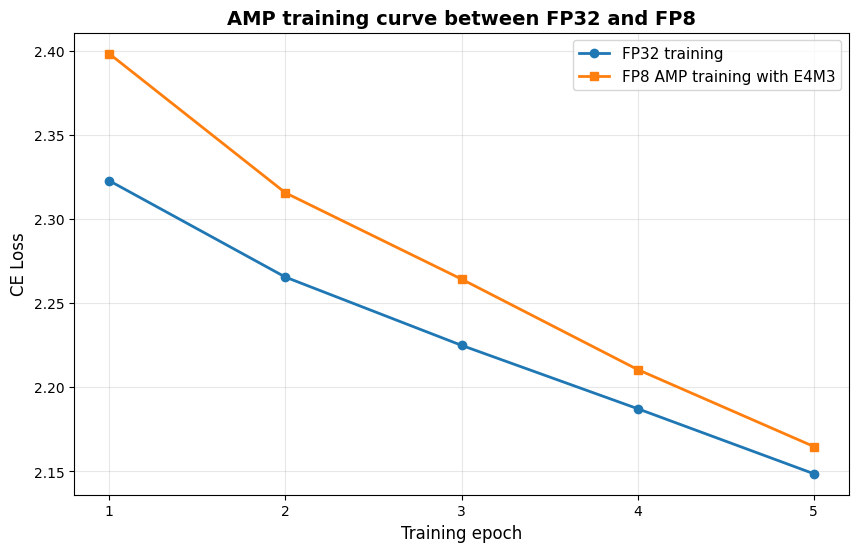

In [6]:
losses_fp32, losses_fp8 = run_comparison_experiment()
import matplotlib.pyplot as plt
# 结果可视化
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses_fp32)+1), losses_fp32, label='FP32 training', marker='o', linewidth=2)
plt.plot(range(1, len(losses_fp8)+1), losses_fp8, label='FP8 AMP training with E4M3', marker='s', linewidth=2)
plt.xlabel('Training epoch', fontsize=12)
plt.ylabel('CE Loss', fontsize=12)
plt.title('AMP training curve between FP32 and FP8', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, len(losses_fp32)+1))
plt.show()

从我们的简化实验中，可以观察到 FP8 混合精度训练与标准 FP32 训练在损失收敛趋势上的差异。由于我们使用的是模拟的 FP8 操作（使用torch内置的cast函数），不会看到明显的训练速度提升，但可以观察到数值精度对训练稳定性的影响。

=== 开始 FP32 训练（基准）===
Epoch  1/5 | 平均损失: 2.3105 | 耗时: 0.04s
Epoch  2/5 | 平均损失: 2.2853 | 耗时: 0.03s
Epoch  3/5 | 平均损失: 2.2581 | 耗时: 0.03s
Epoch  4/5 | 平均损失: 2.2279 | 耗时: 0.03s
Epoch  5/5 | 平均损失: 2.1954 | 耗时: 0.03s

=== 开始 FP8 混合精度训练（E4M3 格式）===
Epoch  1/5 | 平均损失: 2.3218 | 耗时: 0.03s
Epoch  2/5 | 平均损失: 2.2987 | 耗时: 0.03s
Epoch  3/5 | 平均损失: 2.2723 | 耗时: 0.03s
Epoch  4/5 | 平均损失: 2.2431 | 耗时: 0.03s
Epoch  5/5 | 平均损失: 2.2115 | 耗时: 0.03s

为了进一步证明FP8确实可以在训练上进行加速，我们可以用矩阵乘法来模拟（LLM训练中这通常是耗时最长的部分），由于torch官方对fp8的支持仍在实验阶段，我们采用NVIDIA在torch上进一步封装的transformer_engine[pytorch]库来运算。请注意以下的代码在架构较老的机器上(sm<89)很有可能无法运行。

In [7]:
import os
# 测试机器为4090
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import transformer_engine.pytorch as te

def benchmark_linear(layer, x, desc, num_iters=100, fp8_enabled=False):
    # 1. Warmup 
    for _ in range(10):
        if fp8_enabled:
            with te.fp8_autocast(enabled=True):
                _ = layer(x)
        else:
            _ = layer(x)
    
    torch.cuda.synchronize()
    
    # 2. 正式计时
    start_time = time.time()
    for _ in range(num_iters):
        if fp8_enabled:
            with te.fp8_autocast(enabled=True):
                y = layer(x)
        else:
            y = layer(x)
            
    torch.cuda.synchronize()
    end_time = time.time()
    
    avg_time = (end_time - start_time) / num_iters * 1000 # 毫秒
    print(f"[{desc}] 平均耗时: {avg_time:.3f} ms")
    return avg_time
def run_experiment():
    # 检查 GPU
    if not torch.cuda.is_available():
        print("需要 GPU 运行此测试")
        return
    
    device_name = torch.cuda.get_device_name()
    print(f"当前测试显卡: {device_name}")
    
    # 设定参数：矩阵必须足够大才能体现 Tensor Core 的吞吐优势
    # 这里模拟一个大模型的 Linear 层：Hidden Size 4096 -> 16384 (类比Transformer中的FFN)
    B, M, K, N = 32, 4096, 4096, 16384 
    
    # 准备数据 (使用 BF16 作为基准)
    x = torch.randn(B, M, K, device='cuda', dtype=torch.bfloat16)

    # 定义层
    linear = te.Linear(K, N, bias=True).cuda().to(dtype=torch.bfloat16)
    
    print(f"矩阵规模: [{B}x{M}x{K}] x [{K}x{N}]")
    print("-" * 40)
    
    # Test 1: BF16 Baseline
    t_bf16 = benchmark_linear(linear, x, "BF16 (Baseline)", fp8_enabled=False)
    
    # Test 2: FP8 (E4M3)
    # TE 会自动处理 FP8 的 cast 和计算
    t_fp8 = benchmark_linear(linear, x, "FP8  (Enabled) ", fp8_enabled=True)
    
    # 结果分析
    speedup = t_bf16 / t_fp8
    print("-" * 40)
    print(f"加速比 (BF16 / FP8): {speedup:.2f}x")
    
    if speedup > 1.2:
        print("✅ 结论: 检测到硬件 FP8 加速")
    else:
        print("❌ 结论: 未检测到明显加速")
run_experiment()

当前测试显卡: NVIDIA GeForce RTX 4090
矩阵规模: [32x4096x4096] x [4096x16384]
----------------------------------------
[BF16 (Baseline)] 平均耗时: 104.050 ms
[FP8  (Enabled) ] 平均耗时: 84.890 ms
----------------------------------------
加速比 (BF16 / FP8): 1.23x
✅ 结论: 检测到硬件 FP8 加速


通过 NVIDIA 的白皮书，在类似 4090 这种架构（Ada）的显卡上，FP8的吞吐率约为FP32的8倍左右，所以最高能获得8倍的加速。在实际应用中，FP8 混合精度训练相比 FP32 训练通常也能够带来数倍的训练速度提升（具体取决于训练过程中有多少FP8的操作），同时减少至少50%的内存使用。这些优势在大型模型和大规模数据集上尤为明显。

需要注意的是，FP8 训练并不适用于所有场景。当模型具有非常小的梯度或需要高数值精度的任务时，可能需要调整缩放因子或保留某些操作在更高精度下进行。此外在训练中，也不是所有算子都会使用FP8进行训练，比如在 Transformer 结构中 softmax 及 Bias 部分通常会先 cast 到高精度再进行计算。

速度对比：FP8 相比 BF16 在矩阵乘法上有至少1.2倍的加速，考虑到 BF16 矩阵乘法是优化的非常好的算子，因此这个提升还是比较可观的。
精度对比：FP8 训练的损失略高于 FP32（量化噪声导致），但收敛趋势一致，通过这个 toy model 证明其可以进行混合精度训练。

## 6. 总结与思考

本实验介绍了 FP8 混合精度训练的核心概念和实现方法。我们探讨了 FP8 数据格式的数值表示原理，我们基于 torch 官方对于 FP8 的实现进一步构造了一个简化的混合精度训练框架，并讨论了梯度缩放技术以保持数值稳定性。

通过对比实验，我们观察到 FP8 训练在保持模型精度的同时，有可能显著提升训练效率。这种技术特别适用于计算资源受限的环境或需要快速迭代模型的大型项目。

对于想要进一步探索的读者，可以考虑实验不同的缩放策略、尝试更复杂的模型架构，探索哪些算子可以使用 FP8，或者研究其他低精度训练技术如 INT8 量化等。如果对推理感兴趣的，可以继续探索 FP8 matmul 算子在底层是如何实现的。混合精度训练是深度学习工程化中的重要技术，掌握它将有助于在实际项目中实现更高效的模型训练。